In [ ]:
#!pip install tensorflow

In [1]:
import pandas as pd

train = pd.read_csv("traindata.csv")
test = pd.read_csv("testdata.csv") # don't worry about it now

FileNotFoundError: [Errno 2] No such file or directory: 'traindata.csv'

In [ ]:
train

,Unnamed: 0,tmpc,mean_load,min_load,max_load
0,2016-07-31,22.229167,15482.165000,13793.80,16864.44
1,2016-08-01,22.312500,16172.162500,13162.48,18604.17
2,2016-08-02,20.045833,15391.557083,12684.71,17373.11
3,2016-08-03,21.250000,15574.769583,12127.32,18850.84
4,2016-08-04,22.150000,16139.263750,12461.24,19766.81
...,...,...,...,...,...
1974,2021-12-26,3.692500,13274.183750,11827.74,15793.54
1975,2021-12-27,0.090417,14338.343333,11540.32,17178.66
1976,2021-12-28,3.009167,13890.566667,11655.75,16511.29
1977,2021-12-29,2.880000,13931.062500,11464.60,16457.28


In [ ]:
# prompt: rename first column as Date

train.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
train.rename(columns={'tmpc': 'tmpc_max'}, inplace=True)
train.head()

,date,tmpc_max,mean_load,min_load,max_load
0,2016-07-31,22.229167,15482.165000,13793.80,16864.44
1,2016-08-01,22.312500,16172.162500,13162.48,18604.17
2,2016-08-02,20.045833,15391.557083,12684.71,17373.11
3,2016-08-03,21.250000,15574.769583,12127.32,18850.84
4,2016-08-04,22.150000,16139.263750,12461.24,19766.81


In [ ]:
print(train.columns)

Index(['date', 'tmpc_max', 'mean_load', 'min_load', 'max_load'], dtype='object')


In [ ]:
# prompt: add day of the week as a column

train['weekday'] = pd.to_datetime(train['date']).dt.dayofweek+1

train_backup = train
train = train[['tmpc_max', 'weekday', 'mean_load', 'min_load', 'max_load']]


In [ ]:
# climate projection data - ignore for now
# just focus on train
test.rename(columns={'tmpc': 'tmpc_max'}, inplace=True)
test_backup = test
test = test[['tmpc_max']]
test.head()

,tmpc_max
0,-0.83646
1,1.70092
2,2.57000
3,1.11672
4,-2.20210


In [ ]:
test['weekday'] = train['weekday']
test = test[['tmpc_max', 'weekday']]
test.head(2)
test_backup2 = test

In [ ]:
# Perform one-hot encoding with binary values
one_hot_encoded = pd.get_dummies(train['weekday'], prefix='day', dtype=int)
one_hot_encoded.head(2)

,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0


In [ ]:
one_hot_train = pd.concat([train.iloc[:,0:1], one_hot_encoded, train.iloc[:,2:5]], axis=1)
one_hot_train.head(2)

,tmpc_max,day_1,day_2,day_3,day_4,day_5,day_6,day_7,mean_load,min_load,max_load
0,22.229167,0,0,0,0,0,0,1,15482.1650,13793.80,16864.44
1,22.312500,1,0,0,0,0,0,0,16172.1625,13162.48,18604.17


In [ ]:
one_hot_train.shape

(1979, 11)

In [ ]:
# Backup the train data
train_backup2 = train

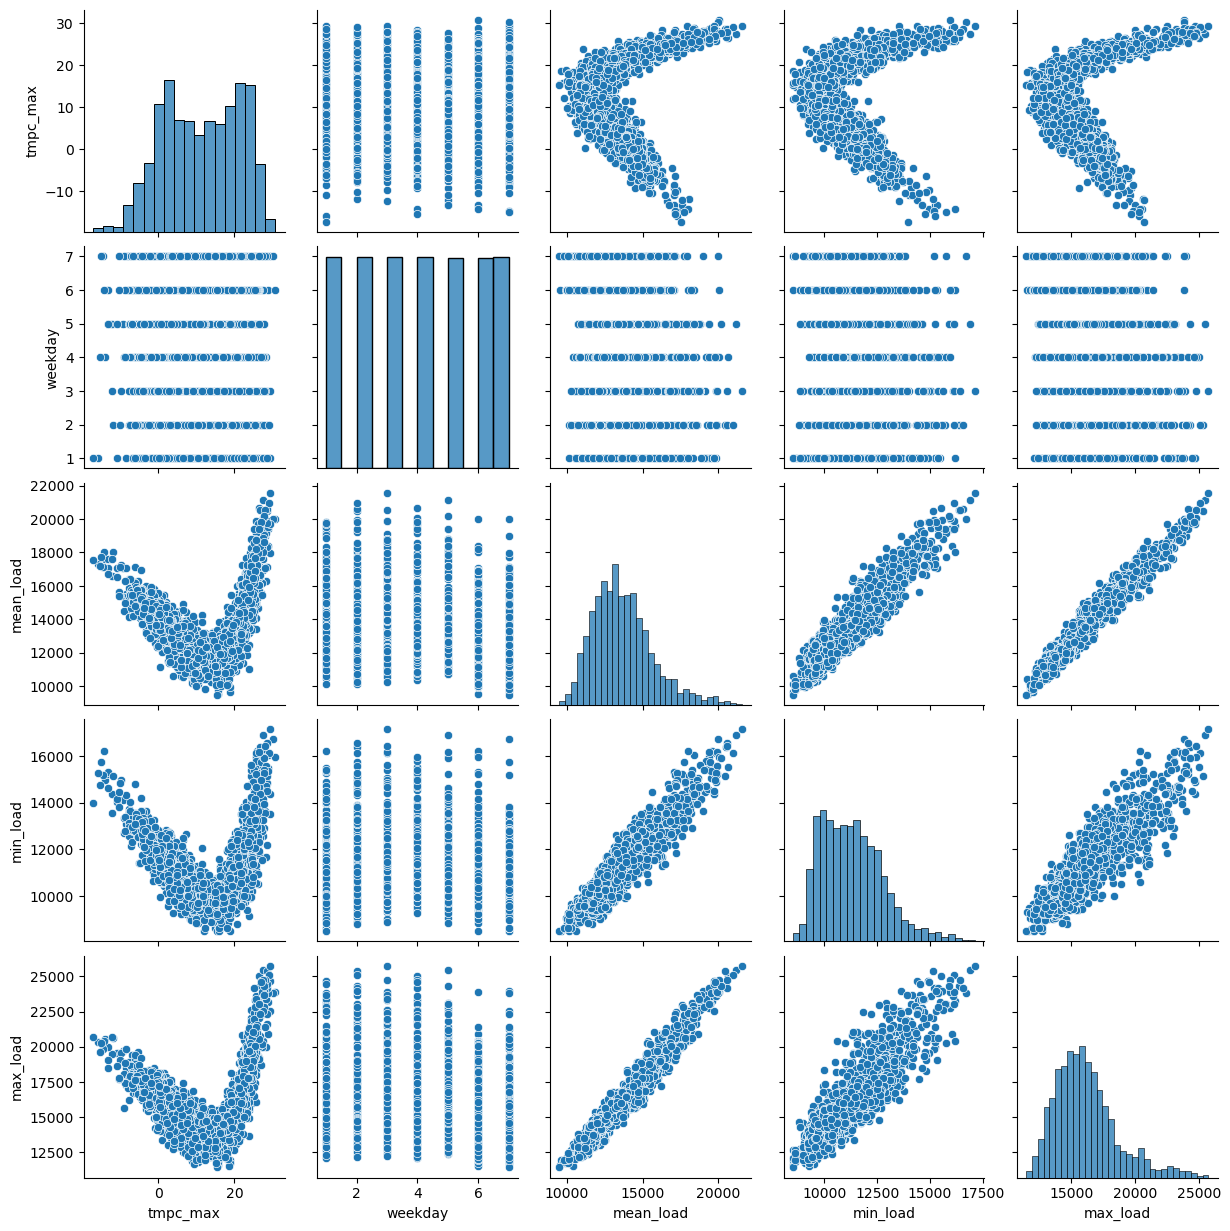

In [ ]:
# prompt: pairplot

import seaborn as sns
sns.pairplot(train)


In [ ]:
import numpy as np

def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    for i in range(len(time_series) - look_back):
        seq_in = time_series[i:(i + look_back), 0:2]  # Assuming 'tmpc_max' is in the first column
        seq_out = time_series[(i + look_back-1), 2:]    # Assuming three output columns starting from the second column
        dataX.append(seq_in)
        dataY.append(seq_out)
    return np.array(dataX), np.array(dataY)

# Example usage:
# Replace 'your_time_series_data' with your actual time series data
# Assuming your data has columns: 'tmpc_max', 'output1', 'output2', 'output3'
your_time_series_data = train.values

# PLAY WITH THIS!
look_back = 10  # Number of previous time steps to use as input features

# Create the dataset
X, y = create_dataset(your_time_series_data, look_back)

# Reshape the data for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], look_back, 2)) # now we have day of week

# Now, X is a 3D tensor that can be used as input for LSTM
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1969, 10, 2)
y shape: (1969, 3)


### Train with Mean data

In [ ]:
# Create a function for one-hot-code data size
train = train_backup2
test = test_backup2
def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    for i in range(len(time_series) - look_back):
        seq_in = time_series[i:(i + look_back), 0:8]  # Assuming 'tmpc_max' is in the first column
        seq_out = time_series[(i + look_back-1), 8:]    # Assuming three output columns starting from the second column
        dataX.append(seq_in)
        dataY.append(seq_out)
    return np.array(dataX), np.array(dataY)

# Example usage:
# Replace 'your_time_series_data' with your actual time series data
# Assuming your data has columns: 'tmpc_max','one_hot_week' 'output1', 'output2', 'output3'
your_time_series_data_one_hot = one_hot_train.values

# PLAY WITH THIS!
look_back = 10  # Number of previous time steps to use as input features

# Create the dataset
X_1hot, y_1hot = create_dataset(your_time_series_data_one_hot, look_back)

# Reshape the data for LSTM input (samples, time steps, features)
X_1hot = np.reshape(X_1hot, (X_1hot.shape[0], look_back, 8)) # now we have day of week in binary 1+7 =8

# Now, X is a 3D tensor that can be used as input for LSTM
print("X_1hot shape:", X_1hot.shape)
print("y_1hot shape:", y_1hot.shape)


X_1hot shape: (1969, 10, 8)
y_1hot shape: (1969, 3)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import relu
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume X and y are already prepared using the create_dataset function

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y = y[:,0]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model using Sequential API
model = Sequential()
model.add(LSTM(units=15,activation=relu, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Add more LSTM layers
model.add(LSTM(units=20, activation=relu))
model.add(Dropout(0.2))

# Add some Dense layers
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1))  # Assuming you have 1 output columns

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use mean squared error for regression tasks

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Fit the model on the training data
history = model.fit(X_train, np.array(y_train), epochs=10000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test data
loss = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")

2024-02-03 23:52:32.782579: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10000
40/40 [==============================] - 1s 11ms/step - loss: 196176704.0000 - val_loss: 173006368.0000
Epoch 2/10000
40/40 [==============================] - 0s 6ms/step - loss: 105137048.0000 - val_loss: 17566438.0000
Epoch 3/10000
40/40 [==============================] - 0s 5ms/step - loss: 20176312.0000 - val_loss: 8732070.0000
Epoch 4/10000
40/40 [==============================] - 0s 5ms/step - loss: 17484782.0000 - val_loss: 7172345.5000
Epoch 5/10000
40/40 [==============================] - 0s 5ms/step - loss: 15466151.0000 - val_loss: 6120976.5000
Epoch 6/10000
40/40 [==============================] - 0s 5ms/step - loss: 14049485.0000 - val_loss: 6056611.5000
Epoch 7/10000
40/40 [==============================] - 0s 5ms/step - loss: 13183893.0000 - val_loss: 5114758.0000
Epoch 8/10000
40/40 [==============================] - 0s 6ms/step - loss: 11762056.0000 - val_loss: 5675217.5000
Epoch 9/10000
40/40 [==============================] - 0s 5ms/step - loss: 1047105

Epoch 1: Training Loss - 196176704.0, Validation Loss - 173006368.0
Epoch 2: Training Loss - 105137048.0, Validation Loss - 17566438.0
Epoch 3: Training Loss - 20176312.0, Validation Loss - 8732070.0
Epoch 4: Training Loss - 17484782.0, Validation Loss - 7172345.5
Epoch 5: Training Loss - 15466151.0, Validation Loss - 6120976.5
Epoch 6: Training Loss - 14049485.0, Validation Loss - 6056611.5
Epoch 7: Training Loss - 13183893.0, Validation Loss - 5114758.0
Epoch 8: Training Loss - 11762056.0, Validation Loss - 5675217.5
Epoch 9: Training Loss - 10471055.0, Validation Loss - 4897353.5
Epoch 10: Training Loss - 10101186.0, Validation Loss - 4672943.0
Epoch 11: Training Loss - 8980711.0, Validation Loss - 5660484.5
Epoch 12: Training Loss - 7896798.5, Validation Loss - 3814450.0
Epoch 13: Training Loss - 7459552.5, Validation Loss - 3643948.25
Epoch 14: Training Loss - 6598440.0, Validation Loss - 3375249.0
Epoch 15: Training Loss - 6813761.5, Validation Loss - 3488087.0
Epoch 16: Training

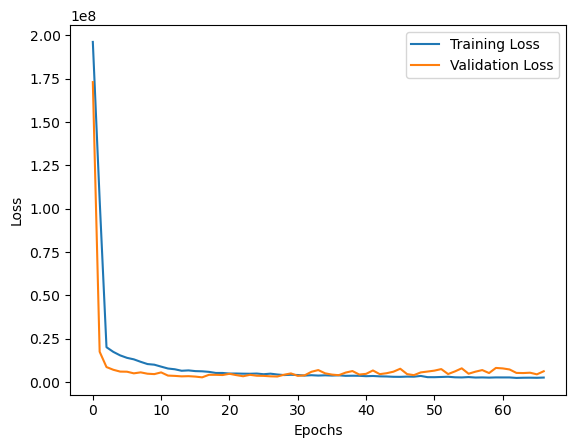

In [ ]:
# check out how the model fit
import matplotlib.pyplot as plt

# Access training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the loss values
for epoch, (train, val) in enumerate(zip(train_loss, val_loss), 1):
    print(f"Epoch {epoch}: Training Loss - {train}, Validation Loss - {val}")

# Plot the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_preds_0 = train_preds
test_preds_0 = test_preds
y_test_0 = y_test

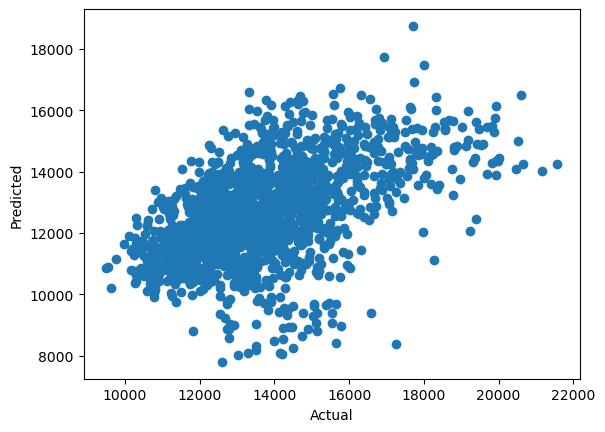

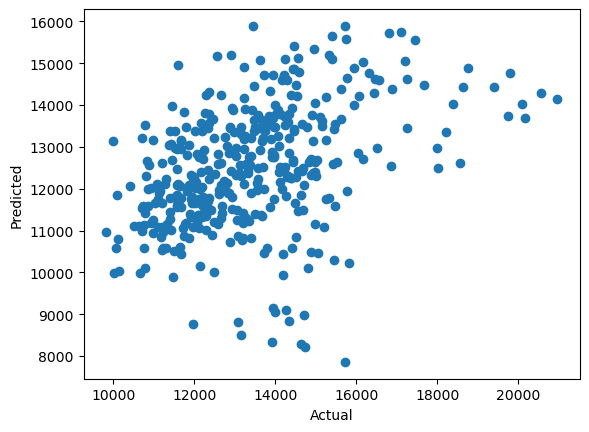

In [ ]:
# prompt: make a plot of train_preds vs y_train, and test_preds and y_test, but each is a list with 3 elements

plt.scatter(y_train, train_preds[:,0]) # mean
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

plt.scatter(y_test, test_preds[:,0])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


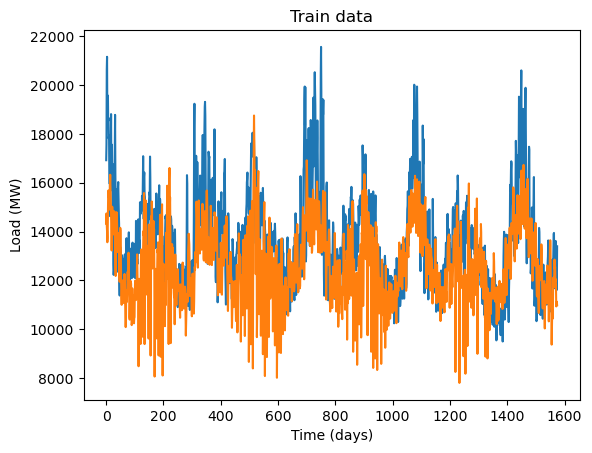

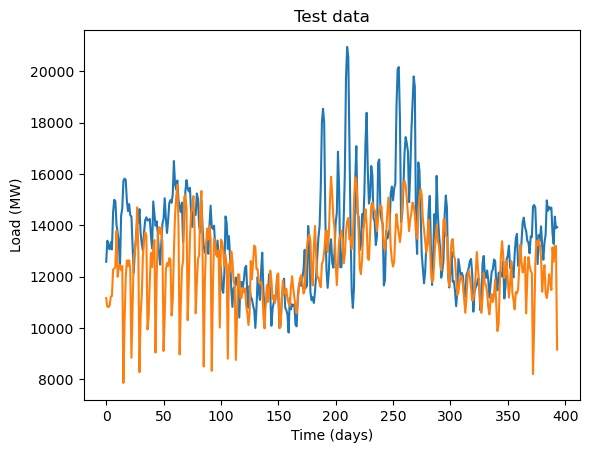

In [ ]:
plt.plot(y_train)
plt.plot(train_preds[:,0])
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Train data')
plt.show()
plt.show()

plt.plot(y_test)
plt.plot(test_preds[:,0])
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Test data')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, test_preds)

# Calculate MSE
mse = mean_squared_error(y_test, test_preds)
mape = mean_absolute_error(y_test, test_preds)

# Calculate RMSE
rmse = np.sqrt(mse)

print(" MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

 MAE: 1516.285060272032
MSE: 4440771.425951405
RMSE: 2107.3137938976733
MAPE: 1516.285060272032


In [ ]:
mape = mean_absolute_error(y_test, test_preds)
print("RMSE:", mape)

RMSE: 1516.285060272032


### Train with minimum data

In [ ]:
import numpy as np
train = train_backup2
test = test_backup2
def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    for i in range(len(time_series) - look_back):
        seq_in = time_series[i:(i + look_back), 0:2]  # Assuming 'tmpc_max' is in the first column
        seq_out = time_series[(i + look_back-1), 2:]    # Assuming three output columns starting from the second column
        dataX.append(seq_in)
        dataY.append(seq_out)
    return np.array(dataX), np.array(dataY)

# Example usage:
# Replace 'your_time_series_data' with your actual time series data
# Assuming your data has columns: 'tmpc_max', 'output1', 'output2', 'output3'
your_time_series_data = train.values

# PLAY WITH THIS!
look_back = 10  # Number of previous time steps to use as input features

# Create the dataset
X, y = create_dataset(your_time_series_data, look_back)

# Reshape the data for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], look_back, 2)) # now we have day of week

# Now, X is a 3D tensor that can be used as input for LSTM
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1969, 10, 2)
y shape: (1969, 3)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assume X and y are already prepared using the create_dataset function

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y = y[:,1]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model using Sequential API
model = Sequential()
model.add(LSTM(units=20,activation=relu, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Add more LSTM layers
model.add(LSTM(units=20, activation=relu))
model.add(Dropout(0.2))

# Add some Dense layers
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1))  # Assuming you have 1 output columns

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use mean squared error for regression tasks

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Fit the model on the training data
history = model.fit(X_train, np.array(y_train), epochs=10000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test data
loss = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")

# Evaluate the model on the test data
loss = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")

Epoch 1/10000
40/40 [==============================] - 1s 12ms/step - loss: 131195544.0000 - val_loss: 108450936.0000
Epoch 2/10000
40/40 [==============================] - 0s 7ms/step - loss: 45007212.0000 - val_loss: 7074912.5000
Epoch 3/10000
40/40 [==============================] - 0s 5ms/step - loss: 12282631.0000 - val_loss: 6770598.0000
Epoch 4/10000
40/40 [==============================] - 0s 5ms/step - loss: 10891069.0000 - val_loss: 4833956.0000
Epoch 5/10000
40/40 [==============================] - 0s 5ms/step - loss: 9887970.0000 - val_loss: 4644766.5000
Epoch 6/10000
40/40 [==============================] - 0s 6ms/step - loss: 8729692.0000 - val_loss: 3849139.5000
Epoch 7/10000
40/40 [==============================] - 0s 6ms/step - loss: 7814455.5000 - val_loss: 3047881.0000
Epoch 8/10000
40/40 [==============================] - 0s 5ms/step - loss: 8073079.5000 - val_loss: 3479026.5000
Epoch 9/10000
40/40 [==============================] - 0s 5ms/step - loss: 6543354.0000 

Epoch 1: Training Loss - 131195544.0, Validation Loss - 108450936.0
Epoch 2: Training Loss - 45007212.0, Validation Loss - 7074912.5
Epoch 3: Training Loss - 12282631.0, Validation Loss - 6770598.0
Epoch 4: Training Loss - 10891069.0, Validation Loss - 4833956.0
Epoch 5: Training Loss - 9887970.0, Validation Loss - 4644766.5
Epoch 6: Training Loss - 8729692.0, Validation Loss - 3849139.5
Epoch 7: Training Loss - 7814455.5, Validation Loss - 3047881.0
Epoch 8: Training Loss - 8073079.5, Validation Loss - 3479026.5
Epoch 9: Training Loss - 6543354.0, Validation Loss - 2523203.75
Epoch 10: Training Loss - 5899238.0, Validation Loss - 2525657.5
Epoch 11: Training Loss - 5744486.5, Validation Loss - 2328268.75
Epoch 12: Training Loss - 5168365.0, Validation Loss - 2355655.75
Epoch 13: Training Loss - 4566927.0, Validation Loss - 2377610.25
Epoch 14: Training Loss - 4723887.0, Validation Loss - 1894667.75
Epoch 15: Training Loss - 4169203.0, Validation Loss - 2440833.0
Epoch 16: Training Los

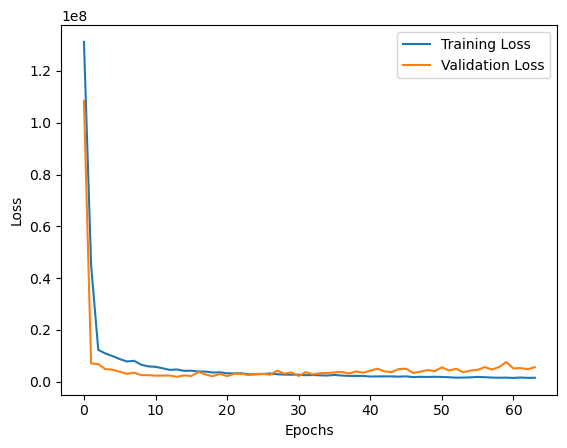

In [ ]:
# check out how the model fit
import matplotlib.pyplot as plt

# Access training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the loss values
for epoch, (train, val) in enumerate(zip(train_loss, val_loss), 1):
    print(f"Epoch {epoch}: Training Loss - {train}, Validation Loss - {val}")

# Plot the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_preds_1 = train_preds
test_preds_1 = test_preds
y_test_1 = y_test

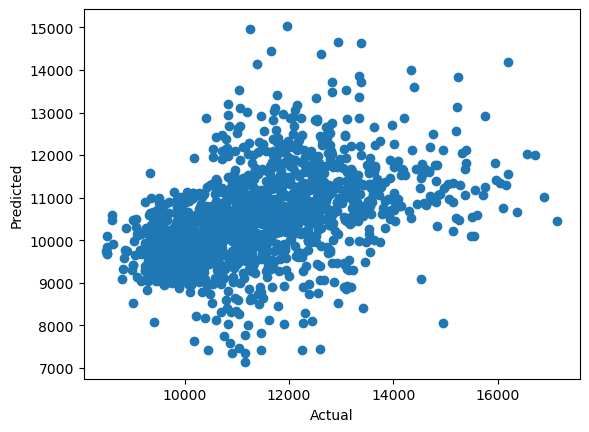

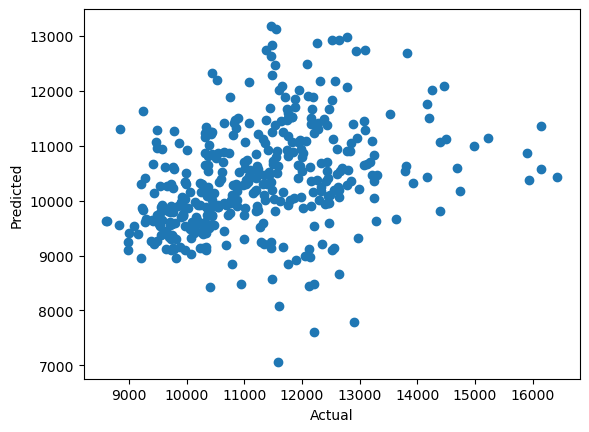

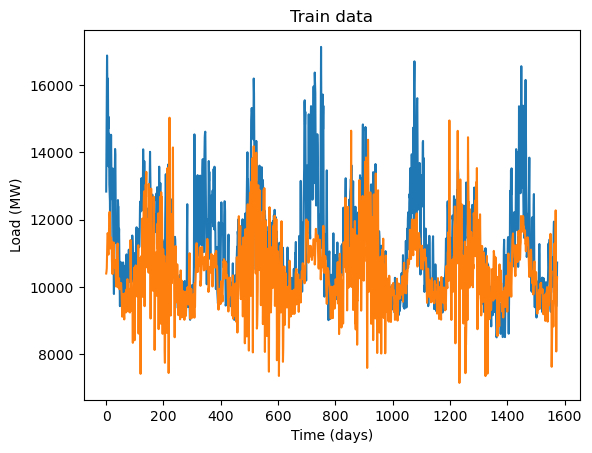

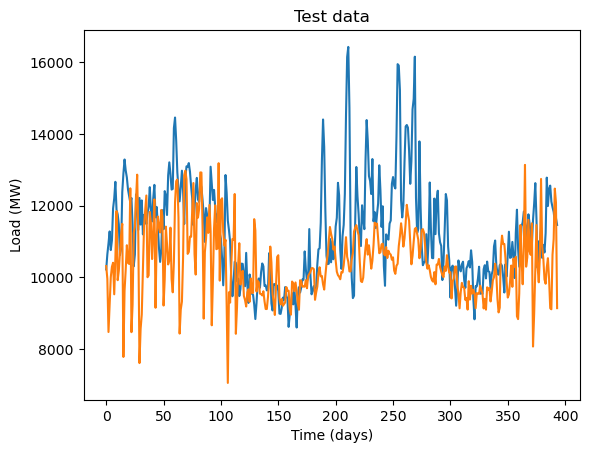

In [ ]:
# prompt: make a plot of train_preds vs y_train, and test_preds and y_test, but each is a list with 3 elements

plt.scatter(y_train, train_preds) # mean
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

plt.scatter(y_test, test_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

plt.plot(y_train)
plt.plot(train_preds)
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Train data')
plt.show()
plt.show()

plt.plot(y_test)
plt.plot(test_preds)
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Test data')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, test_preds)

# Calculate MSE
mse = mean_squared_error(y_test, test_preds)
mape = mean_absolute_error(y_test, test_preds)

# Calculate RMSE
rmse = np.sqrt(mse)

print(" MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

 MAE: 1210.5418398536642
MSE: 2740961.4275552123
RMSE: 1655.5849200675912
MAPE: 1210.5418398536642


### With Maximum load

In [ ]:
import numpy as np
train = train_backup2
test = test_backup2
def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    for i in range(len(time_series) - look_back):
        seq_in = time_series[i:(i + look_back), 0:2]  # Assuming 'tmpc_max' is in the first column
        seq_out = time_series[(i + look_back-1), 2:]    # Assuming three output columns starting from the second column
        dataX.append(seq_in)
        dataY.append(seq_out)
    return np.array(dataX), np.array(dataY)

# Example usage:
# Replace 'your_time_series_data' with your actual time series data
# Assuming your data has columns: 'tmpc_max', 'output1', 'output2', 'output3'
your_time_series_data = train.values

# PLAY WITH THIS!
look_back = 10  # Number of previous time steps to use as input features

# Create the dataset
X, y = create_dataset(your_time_series_data, look_back)

# Calculate the mean of the target
mean_value = np.mean(y)

# Define a threshold for identifying outliers
# Using standard deviation or interquartile range (IQR)
# Here, outside of 3 standard deviations as outliers
std_dev = np.std(y)
threshold = 3 * std_dev

# Identify outliers
outliers = np.abs(y - mean_value) > threshold

# Replace outliers with the mean of the dataset
y[outliers] = mean_value


# Reshape the data for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], look_back, 2)) # now we have day of week

# Now, X is a 3D tensor that can be used as input for LSTM
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1969, 10, 2)
y shape: (1969, 3)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume X and y are already prepared using the create_dataset function

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y = y[:,2]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model using Sequential API
model = Sequential()
model.add(LSTM(units=20,activation=relu, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Add more LSTM layers
model.add(LSTM(units=20, activation=relu))
model.add(Dropout(0.2))

# Add some Dense layers
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1))  # Assuming you have 1 output columns

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use mean squared error for regression tasks

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Fit the model on the training data
history = model.fit(X_train, np.array(y_train), epochs=10000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test data
loss = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")

# Evaluate the model on the test data
loss = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")

Epoch 1/10000
40/40 [==============================] - 1s 11ms/step - loss: 258580112.0000 - val_loss: 223831648.0000
Epoch 2/10000
40/40 [==============================] - 0s 6ms/step - loss: 115320776.0000 - val_loss: 18646680.0000
Epoch 3/10000
40/40 [==============================] - 0s 5ms/step - loss: 29002990.0000 - val_loss: 13800363.0000
Epoch 4/10000
40/40 [==============================] - 0s 5ms/step - loss: 22412256.0000 - val_loss: 12259415.0000
Epoch 5/10000
40/40 [==============================] - 0s 5ms/step - loss: 21342010.0000 - val_loss: 10734177.0000
Epoch 6/10000
40/40 [==============================] - 0s 6ms/step - loss: 18867298.0000 - val_loss: 9726471.0000
Epoch 7/10000
40/40 [==============================] - 0s 6ms/step - loss: 17374026.0000 - val_loss: 10385532.0000
Epoch 8/10000
40/40 [==============================] - 0s 5ms/step - loss: 16723061.0000 - val_loss: 8764978.0000
Epoch 9/10000
40/40 [==============================] - 0s 5ms/step - loss: 156

40/40 [==============================] - 0s 5ms/step - loss: 3869392.7500 - val_loss: 11394437.0000
Epoch 73/10000
40/40 [==============================] - 0s 5ms/step - loss: 4266863.5000 - val_loss: 9813874.0000
Epoch 74/10000
40/40 [==============================] - 0s 5ms/step - loss: 4211792.5000 - val_loss: 15249091.0000
Epoch 75/10000
40/40 [==============================] - 0s 5ms/step - loss: 4045933.0000 - val_loss: 15310305.0000
Epoch 76/10000
13/13 [==============================] - 0s 1ms/step - loss: 5171630.0000
Test Loss: 5171630.0
13/13 [==============================] - 0s 1ms/step - loss: 5171630.0000
Test Loss: 5171630.0


Epoch 1: Training Loss - 258580112.0, Validation Loss - 223831648.0
Epoch 2: Training Loss - 115320776.0, Validation Loss - 18646680.0
Epoch 3: Training Loss - 29002990.0, Validation Loss - 13800363.0
Epoch 4: Training Loss - 22412256.0, Validation Loss - 12259415.0
Epoch 5: Training Loss - 21342010.0, Validation Loss - 10734177.0
Epoch 6: Training Loss - 18867298.0, Validation Loss - 9726471.0
Epoch 7: Training Loss - 17374026.0, Validation Loss - 10385532.0
Epoch 8: Training Loss - 16723061.0, Validation Loss - 8764978.0
Epoch 9: Training Loss - 15665952.0, Validation Loss - 8045430.0
Epoch 10: Training Loss - 15001551.0, Validation Loss - 7344139.5
Epoch 11: Training Loss - 14585793.0, Validation Loss - 7239684.0
Epoch 12: Training Loss - 12805732.0, Validation Loss - 6569917.5
Epoch 13: Training Loss - 10544734.0, Validation Loss - 6963883.5
Epoch 14: Training Loss - 11388735.0, Validation Loss - 5964232.5
Epoch 15: Training Loss - 9956396.0, Validation Loss - 5892606.5
Epoch 16: T

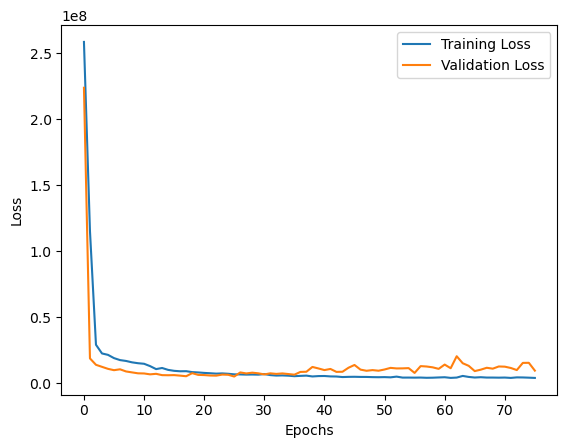

In [ ]:
# check out how the model fit
import matplotlib.pyplot as plt

# Access training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the loss values
for epoch, (train, val) in enumerate(zip(train_loss, val_loss), 1):
    print(f"Epoch {epoch}: Training Loss - {train}, Validation Loss - {val}")

# Plot the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_preds_2 = train_preds
test_preds_2 = test_preds
y_test_2 = y_test

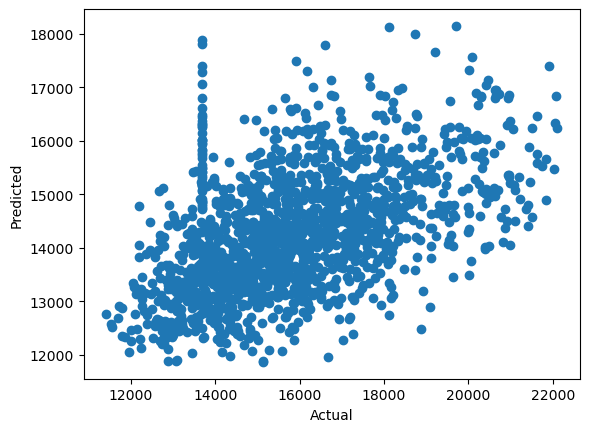

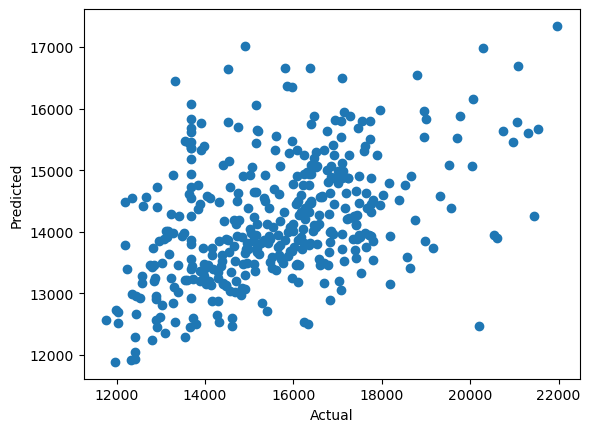

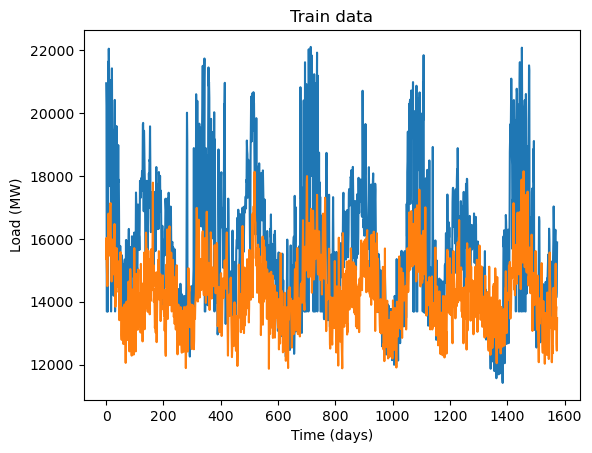

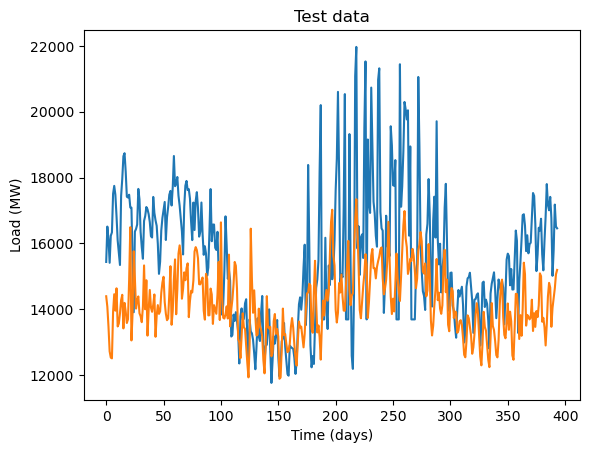

In [ ]:
# prompt: make a plot of train_preds vs y_train, and test_preds and y_test, but each is a list with 3 elements

plt.scatter(y_train, train_preds) # mean
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

plt.scatter(y_test, test_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

plt.plot(y_train)
plt.plot(train_preds)
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Train data')
plt.show()
plt.show()

plt.plot(y_test)
plt.plot(test_preds)
plt.xlabel('Time (days)')
plt.ylabel('Load (MW)')
plt.title('Test data')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, test_preds)

# Calculate MSE
mse = mean_squared_error(y_test, test_preds)

mape = mean_absolute_error(y_test,test_preds)

# Calculate RMSE
rmse = np.sqrt(mse)

print(" MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE", mape)

 MAE: 1828.4676873702563
MSE: 5171629.903179485
RMSE: 2274.121787235566
MAPE 1828.4676873702563


### Plot all predicted plots.

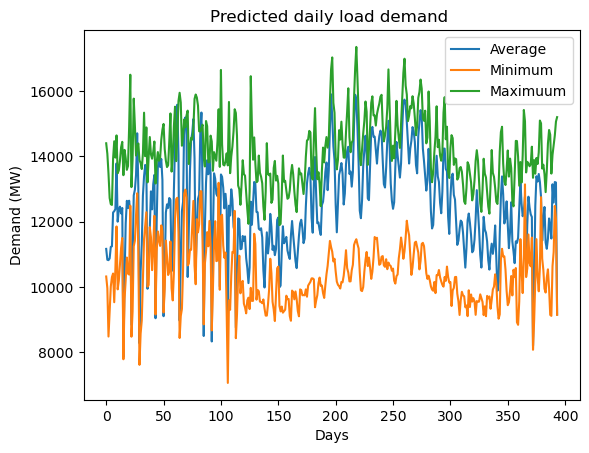

In [ ]:
plt.plot(test_preds_0, label='Average')
plt.plot(test_preds_1, label='Minimum')
plt.plot(test_preds_2, label='Maximuum')
plt.ylabel('Demand (MW)')
plt.xlabel('Days')
plt.title('Predicted daily load demand ')
plt.legend()
plt.show()

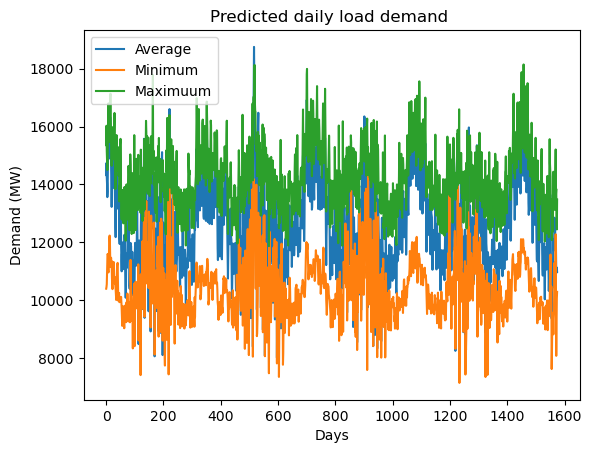

In [ ]:
plt.plot(train_preds_0, label='Average')
plt.plot(train_preds_1, label='Minimum')
plt.plot(train_preds_2, label='Maximuum')
plt.ylabel('Demand (MW)')
plt.xlabel('Days')
plt.title('Predicted daily load demand ')
plt.legend()

### Plot Histogram

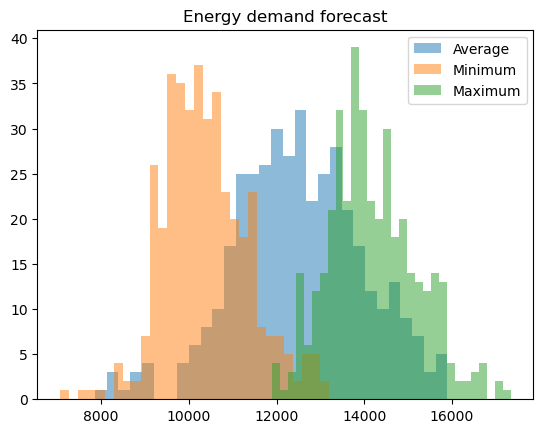

In [ ]:
plt.hist(test_preds_0, bins=30, alpha=0.5, label='Average')
plt.hist(test_preds_1, bins=30, alpha=0.5, label='Minimum')
plt.hist(test_preds_2, bins=30, alpha=0.5, label='Maximum')
plt.legend()
plt.title("Energy demand forecast")
plt.show()


In [ ]:
errors_0 = np.absolute(test_preds_0.reshape(-1) - y_test_0)
errors_1 = np.absolute(test_preds_1.reshape(-1) - y_test_1)
errors_2 = np.absolute(test_preds_2.reshape(-1) - y_test_2)

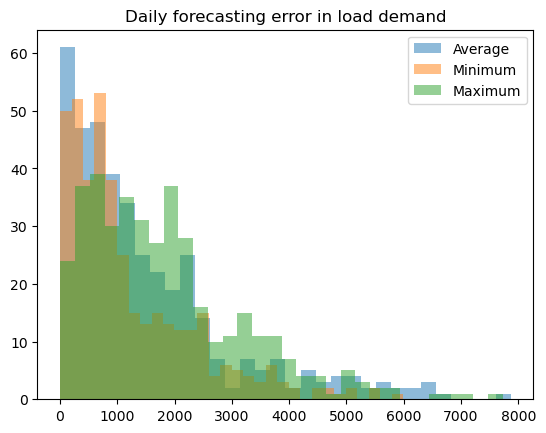

In [ ]:
plt.hist(errors_0, bins=30, alpha=0.5, label='Average')
plt.hist(errors_1, bins=30, alpha=0.5, label='Minimum')
plt.hist(errors_2, bins=30, alpha=0.5, label='Maximum')
plt.legend()
plt.title("Daily forecasting error in load demand")
plt.show()

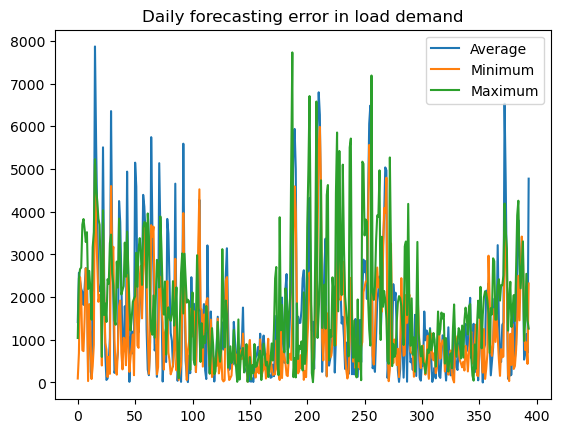

In [ ]:
plt.plot(errors_0, label='Average')
plt.plot(errors_1, label='Minimum')
plt.plot(errors_2, label='Maximum')
plt.legend()
plt.title("Daily forecasting error in load demand")
plt.show()

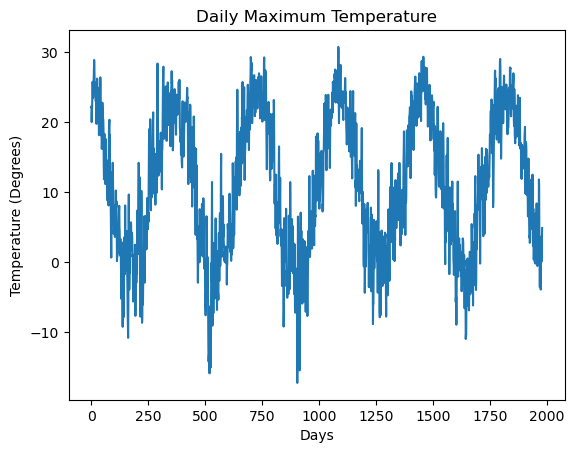

In [ ]:
plt.plot(train_backup2['tmpc_max'])
plt.title('Daily Maximum Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (Degrees)')
plt.show()

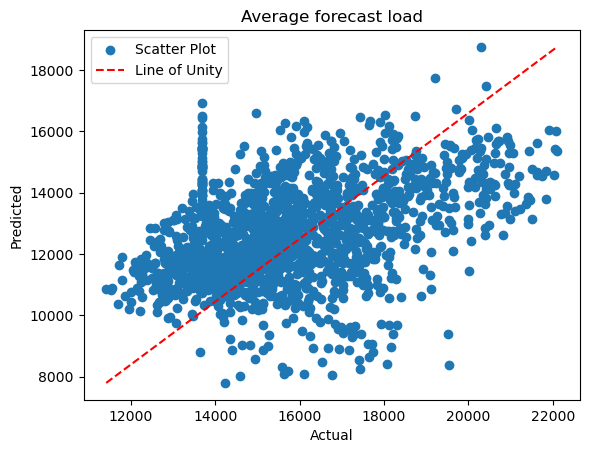

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot using train data
plt.scatter(y_train, train_preds_0, label='Scatter Plot')

# Plotting a line between the points
plt.plot([min(y_train), max(y_train)], [min(train_preds_0), max(train_preds_0)], color='red', linestyle='--', label='Line of Unity')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Average forecast load')
plt.show()


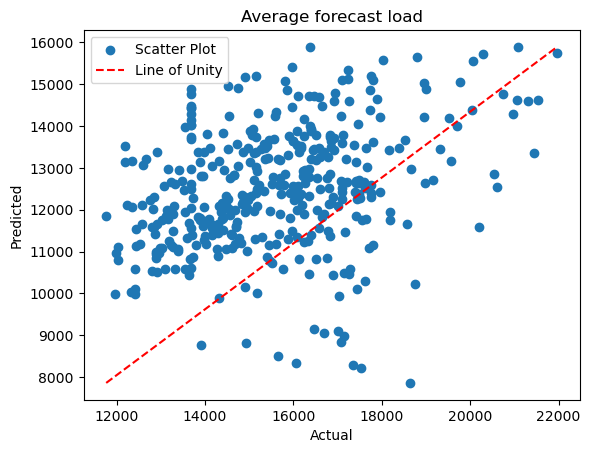

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot using testing data
plt.scatter(y_test, test_preds_0, label='Scatter Plot')

# Plotting a line between the points
plt.plot([min(y_test), max(y_test)], [min(test_preds_0), max(test_preds_0)], color='red', linestyle='--', label='Line of Unity')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Average forecast load')
plt.show()


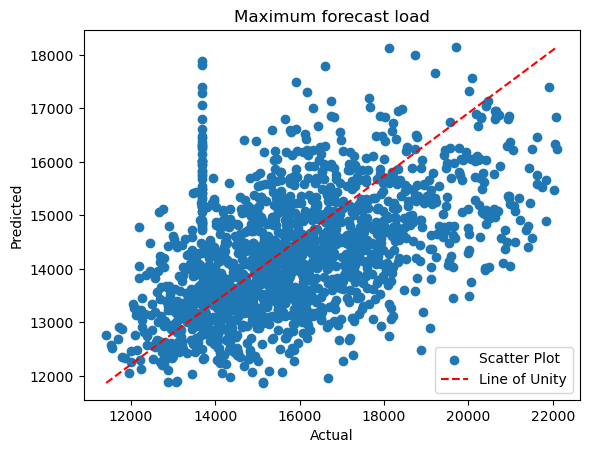

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot train data
plt.scatter(y_train, train_preds, label='Scatter Plot')

# Plotting a line between the points
plt.plot([min(y_train), max(y_train)], [min(train_preds_2), max(train_preds_2)], color='red', linestyle='--', label='Line of Unity')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Maximum forecast load')
plt.show()


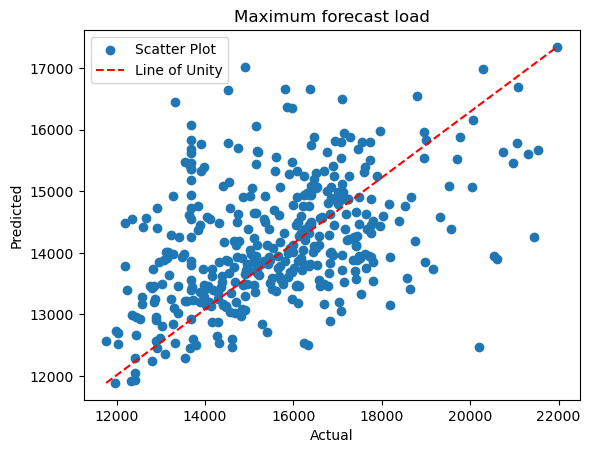

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot using testing data
plt.scatter(y_test, test_preds_2, label='Scatter Plot')

# Plotting a line between the points
plt.plot([min(y_test), max(y_test)], [min(test_preds_2), max(test_preds_2)], color='red', linestyle='--', label='Line of Unity')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Maximum forecast load')
plt.show()
